In [18]:
# import packages
from fractions import Fraction
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import cvxpy as cvx
import math
import random
# from collections import deque

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

usage matrix using recursive function:
[[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
usage matrix using networkx method:
[[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
usage matrix using improved recursive function:
[[1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 0. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Outputs of all methods are equal: True


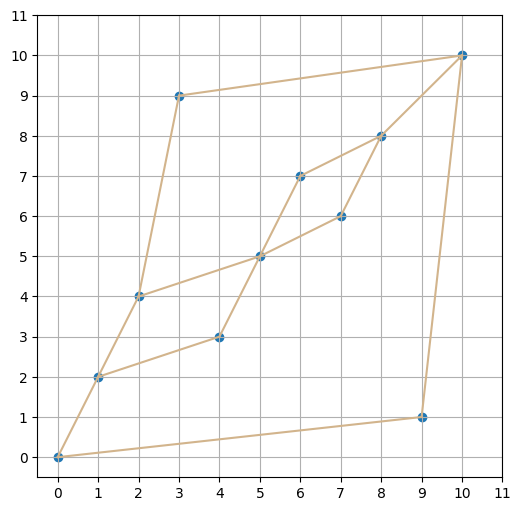

In [3]:
def all_connections(s):
    """returns all valid connections in MISS

    Args:
        s (list): sequence to generate connections from

    Returns:
        list of tuples: (x1, x2) where (x1, s[x1]) (x2, s[x2]) is a valid connection of up and right paths that are part of a MISS
    """
    # adding auxilary source and sink
    s = s.copy()
    s.insert(0, 0)
    s.append(len(s))

    connections = []
    for i in range(len(s)):
        for j in range(i, len(s)):
            # using the above rule
            if ((j - i) * (s[j] - s[i])) > 0:
                connections.append((i, j))
    # gets rid of duplicates
    connections = list(set(connections))

    plt.figure(figsize=(6, 6))
    plt.scatter(range(0, len(s)), s)

    valid_connections = set()

    for connection in connections:
        if not in_box(connection, s):
            valid_connections.add((connection[0] + 1, connection[1] + 1))
            x1, x2 = connection[0], connection[1]
            plt.plot([x1, x2], [s[x1], s[x2]], color='tan')

    plt.xticks(range(0, len(s) + 1))
    plt.yticks(range(0, len(s) + 1))
    plt.grid(True)

    connections = sorted(list(valid_connections))

    return connections


def in_box(t, s):
    """returns whether there is another point in the box extending horizontal and vertical lines from both points

    Args:
        t (tuple): connection to be checked
        s (list): main seequence

    Returns:
        bool: whether there exists a point in the box
    """
    i, j = t[0], t[1]
    if any(s[x] < s[j] and s[x] > s[i] for x in range(i + 1, j)):
        return True
    return False

def find_sources(s):
    """finds sources of a sequence (all sources of MISS)

    Args:
        s (list): main sequence

    Returns:
        list: indices of source nodes
    """
    return [i for i, element in enumerate(s) if all(element < x for x in s[:i])]

def recursive_method(s):
    """calls recursive function to find all MISS

    Args:
        s (list): main sequence

    Returns:
        2D numpy array: usage matrix MISS
    """
    m = np.empty((0, len(s)))
    def recurse(s, x, row):
        row[x] = 1
        greater = []
        for i in range(x, len(s)):
            if s[i] > s[x] and all(s[j] > s[i] for j in greater):
                greater.append(i)
        if len(greater) == 0:
            nonlocal m
            m = np.concatenate((m, [row]), axis=0)
            return
        for element in greater:
            recurse(s, element, row.copy())

    for source in find_sources(s):
        recurse(s, source, np.zeros(len(s))) 
    return m

def MISS_from_connections(c, s_len):
    """uses networkx to find the usage matrix of MISS from a list of possible valid connections

    Args:
        c (list of tuples): connections

    Returns:
        2D numpy array: usage matrix
    """
    g = nx.DiGraph()
    g.add_edges_from(c)
    
    m = np.empty((0, s_len))
        
    sink_nodes = [node for node, out_degree in g.out_degree() if out_degree == 0]
    source_nodes = [node for node, in_degree in g.in_degree() if in_degree == 0]
    for (source, sink) in [(source, sink) for sink in sink_nodes for source in source_nodes]:
        for path in nx.all_simple_paths(g, source=source, target=sink):
            row = np.zeros(s_len)
            for i in path:
                # shifting since auxiliary source and sink should not be in usage matrix
                if i != 1 and i != s_len+2:
                    row[i - 2] = 1
            m = np.concatenate((m, [row]), axis=0)

    return m

def networkx_method(pi):
    return MISS_from_connections(all_connections(pi), len(pi))

def improved_recursive(s):
    m_rows = []

    def recurse(s, x, row):
        row[x] = 1
        greater = []
        for i in range(x, len(s)):
            if s[i] > s[x] and all(s[j] > s[i] for j in greater):
                greater.append(i)
        if not greater:
            m_rows.append(row.copy())
            return
        for element in greater:
            recurse(s, element, row)
            row[element] = 0
            
    for i, element in enumerate(s):
        if all(element < x for x in s[:i]):
            recurse(s, i, np.zeros(len(s)))
        
    return np.array(m_rows)

# pi = [7, 3, 1, 17, 10, 18, 9, 20, 6, 12, 16, 13, 2, 8, 19, 4, 15, 11, 14, 5]
pi = [2, 4, 9, 3, 5, 7, 6, 8, 1]
# pi = [2, 1, 4, 5, 3]

print("usage matrix using recursive function:")
r = recursive_method(pi)
r = r[np.lexsort(r.T)]
print(r)
print("usage matrix using networkx method:")
n = networkx_method(pi)
n = n[np.lexsort(n.T)]
print(n)
print("usage matrix using improved recursive function:")
i = improved_recursive(pi)
i = i[np.lexsort(i.T)]
print(i)

print(f"Outputs of all methods are equal: {np.array_equal(n, r) and np.array_equal(n, i)}")

In [46]:
def find_sources(s):
    return [i for i, element in enumerate(s) if all(element < x for x in s[:i])]

def generate_N(s):
    m_rows = []

    def recurse(s, x, row):
        row[x] = 1
        greater = []
        for i in range(x, len(s)):
            if s[i] > s[x] and all(s[j] > s[i] for j in greater):
                greater.append(i)
        if not greater:
            m_rows.append(row.copy())
            return
        for element in greater:
            recurse(s, element, row)
            row[element] = 0
            
    for i, element in enumerate(s):
        if all(element < x for x in s[:i]):
            recurse(s, i, np.zeros(len(s)))
        
    return np.array(m_rows)

def shortest_path(s, w):
    m = np.empty((0, len(s)))
    lightest = np.empty(len(s))
    lightest_value = math.inf
    def recurse(s, x, row):
        row[x] = 1
        greater = []
        for i in range(x, len(s)):
            if s[i] > s[x] and all(s[j] > s[i] for j in greater):
                greater.append(i)
        if len(greater) == 0:
            nonlocal m, lightest, lightest_value
            m = np.concatenate((m, [row]), axis=0)
            value = np.dot(row, w)
            if value < lightest_value:
                lightest_value = value
                lightest = row
            return
        for element in greater:
            recurse(s, element, row.copy())

    for source in find_sources(s):
        recurse(s, source, np.zeros(len(s))) 

    return m, lightest, lightest_value

# this doens't return N but does give the correct value for modulus
def fast_shortest_path(s, w):
    m_rows = []
    lightest = []
    lightest_value = math.inf

    def recurse(s, x, row):
        nonlocal m_rows, lightest, lightest_value
        row[x] = 1
        value = row @ w
        if value > lightest_value:
            return
        greater = []
        for i in range(x, len(s)):
            if s[i] > s[x] and all(s[j] > s[i] for j in greater):
                greater.append(i)
        if not greater:
            m_rows.append(row.copy())
            if value < lightest_value:
                lightest_value = value
                lightest = row.copy()
            return
        for element in greater:
            recurse(s, element, row)
            row[element] = 0
            
    for i, element in enumerate(s):
        if all(element < x for x in s[:i]):
            recurse(s, i, np.zeros(len(s)))

    return lightest, lightest_value

def add_constraint(N, c):
    if N is None:
        return c
    return np.vstack((N, c))

def modulus(N, p):
    n = N.shape[-1]

    rho = cvx.Variable(n)

    cons = [rho >= 0, N@rho >= 1]

    obj = cvx.Minimize(cvx.pnorm(1**(1/p)*rho, p)**p)

    prob = cvx.Problem(obj, cons)
    prob.solve(solver=cvx.ECOS)

    return obj.value, np.array(rho.value).flatten()

def ssmodulus(pi, p, display=True):
    rho = np.zeros(len(pi))
    mod = 0
    tol = 1e-5
    N = None

    while True:
        m, gP, lv = shortest_path(pi, rho)

        if lv > 1 - tol:
            if display:
                plt.figure(figsize=(6, 6))
                plt.scatter(range(1, len(pi) + 1), pi)
                plt.title(f'Modulus: {round(mod, 3)}')
                for row in m:
                    indices = np.nonzero(row)
                    plt.plot(indices[0] + 1, [pi[i] for i in indices[0]], color='tan')
                for i, j in enumerate(pi):
                    plt.annotate(round(rho[i], 3), (i + 1, j), xycoords='data', xytext=(4, 4), textcoords='offset points')
                plt.xticks(range(0, len(pi) + 2))
                plt.yticks(range(0, len(pi) + 2))
                plt.grid(True)
            return mod, rho, m
        
        N = add_constraint(N, gP)

        mod, rho = modulus(N, p)


def fast_ssmodulus(pi, p, display=False):
    rho = np.zeros(len(pi))
    mod = 0
    tol = 1e-5
    N = None

    while True:
        gP, lv = fast_shortest_path(pi, rho)

        if lv > 1 - tol:
            return mod
            # return mod, rho

        N = add_constraint(N, gP)

        mod, rho = modulus(N, p)

def faster_ssmodulus(pi, p, display=False):
    rho = np.zeros(len(pi))
    mod = 0
    tol = 1e-5
    N = generate_N(pi)
    m = None

    # print(len(N))

    # def faster_shortest_path(rho):
    #     lightest_value = math.inf
    #     lightest = []
    #     for row in N:
    #         value = row @ rho
    #         if value < lightest_value:
    #             lightest_value = value
    #             lightest = row
    #     return lightest, lightest_value

    mod, _ = modulus(N, p)

    return mod

    # while True:
    #     # print("running")
    #     gP, lv = faster_shortest_path(rho)

    #     if lv > 1 - tol:
    #         return mod
    #         # return mod, rho

    #     m = add_constraint(m, gP)

    #     mod, rho = modulus(m, p)

# pi = [7, 3, 1, 17, 10, 18, 9, 20, 6, 12, 16, 13, 2, 8, 19, 4, 15, 11, 14, 5]

n = 50
pi = random.sample(range(1, n + 1), n)

print(ssmodulus(pi, 2, False))
print(fast_ssmodulus(pi, 2))
print(faster_ssmodulus(pi, 2))


(1.4837982336490312, array([2.96395703e-01, 5.25602174e-02, 1.25155787e-03, 2.96395701e-01,
       5.38117656e-02, 1.50267292e-02, 2.96395693e-01, 5.38117830e-02,
       5.38117751e-02, 1.08409864e-01, 1.46485978e-01, 1.50267311e-02,
       3.53421738e-06, 2.98215460e-01, 5.97709197e-02, 2.38444575e-01,
       6.88384920e-02, 1.50267196e-02, 5.00569222e-02, 5.13084777e-02,
       3.51365411e-06, 6.88384933e-02, 8.30244426e-02, 2.96395701e-01,
       6.88384936e-02, 7.76474851e-02, 5.97709197e-02, 5.37696263e-03,
       8.84013967e-02, 6.88384865e-02, 5.25231173e-02, 3.50302113e-02,
       6.34000351e-02, 8.49653033e-02, 5.79615633e-02, 5.43846336e-03,
       6.75498362e-02, 7.76474848e-02, 1.18902741e-01, 2.34445615e-02,
       1.46485978e-01, 1.18902736e-01, 6.15206847e-02, 1.36395642e-01,
       9.37783595e-02, 4.63339960e-01, 1.31854479e-01, 4.63339965e-01,
       1.46485978e-01, 5.57118321e-01]), array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1.

In [47]:
n = 50
pi = random.sample(range(1, n + 1), n)
print("pi: ", pi)
print("base method: ", end="")
%timeit -r1 -n 1 ssmodulus(pi, 2, display=False)
print("\"improved\" method: ", end="")
%timeit -r1 -n 1 fast_ssmodulus(pi, 2)
print("more improved? method: ", end="")
%timeit -r1 -n 1 faster_ssmodulus(pi, 2)

pi:  [35, 14, 28, 5, 37, 11, 42, 26, 27, 49, 2, 4, 8, 18, 15, 24, 45, 38, 22, 16, 12, 40, 6, 48, 44, 29, 33, 31, 25, 3, 47, 17, 50, 23, 30, 43, 41, 39, 34, 36, 20, 46, 32, 19, 10, 9, 21, 1, 7, 13]
base method: 485 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
"improved" method: 196 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
more improved? method: 16.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
